## Setup

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy_indexed as npi
from tqdm.notebook import tqdm

from ipywidgets import interact, widgets
from plotly.express import imshow as imshow_interactive

In [2]:
import os
import pathlib
from typing import List, Tuple
import numpy as np
import cv2 as cv
from sklearn.cluster import AgglomerativeClustering
from dotenv import load_dotenv


BASE_DIR = pathlib.Path(__name__).resolve().parent.parent.parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

## Import core modules

In [3]:
import sys
import pathlib
SRC_DIR = str(pathlib.Path(__name__).resolve().parent.parent.parent)
sys.path.append(SRC_DIR)

In [ ]:
from scanplot.setup_logger import logger

In [ ]:
from scanplot.utils.read_image import read_image_rgb, read_image_gray
from scanplot.utils.drawing import draw_image, draw_points_on_canvas, draw_points_on_image, \
    draw_bbox

In [ ]:
from scanplot.core.template_match import template_match, detect_points, \
    find_tolerance_limit, point_to_bbox

from scanplot.core.clustering import simplify_points, agglomerative_clustering, meanshift_clustering

from scanplot.core.preprocess import replace_black_pixels

from scanplot.core.conv_map_operations import invert_convolution_map, normalize_map, \
    get_first_N_maximums, remove_nan_inf


from scanplot.core.process_template import template_tresholding, extract_largest_component, find_bbox, \
    crop_image, frame_image, is_grayscale, reconstruct_template_mask

from scanplot.core.hough_transform import calc_gradients, build_hough_model, fill_accumulator

In [ ]:
# convolution implementation
from scanplot.core.convolution_from_stratch import get_image_part, sqdiff, \
    compute_mask_pixel_ratio, compute_mask_pixel_ratio_v2, sqdiff_normed_modification, \
    sqdiff_normed, cv_sqdiff_normed

## Pipeline 1 (corr map from OpenCV + postprocessing)

In [8]:
PLOT_NUMBER = 50
MARKER_NUMBER = 1

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [198]:
source_image = read_image_rgb(PLOT_PATH)
template_rgb = read_image_rgb(TEMPLATE_PATH)

In [199]:
h_image, w_image = source_image.shape[0], source_image.shape[1]
h_template, w_template = template_rgb.shape[0], template_rgb.shape[1]

h_image, w_image

(1184, 1732)

([], [])

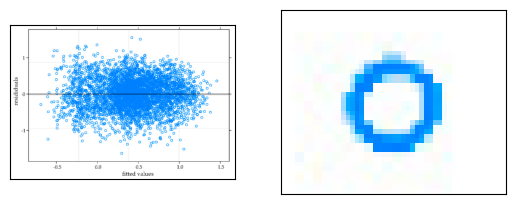

In [200]:
plt.subplot(1, 2, 1)
draw_image(source_image)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(template_rgb)
plt.xticks([]); plt.yticks([])

**Add ROI**

In [201]:
# imshow_interactive(source_image)

In [202]:
# x_min, x_max, y_min, y_max = 221, 458, 47, 418
# roi_bbox = (x_min, x_max, y_min, y_max)

# source_image = crop_image(source_image, roi_bbox)

In [203]:
# imshow_interactive(source_image)

**Tresholding**

([], [])

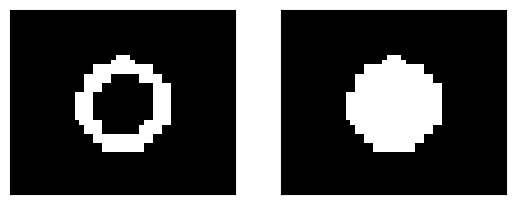

In [204]:
TRESHOLD_VALUE = 190
template_mask = template_tresholding(template_rgb, TRESHOLD_VALUE)
new_template_mask = reconstruct_template_mask(template_mask)

fig = plt.figure()
plt.subplot(1, 2, 1)
draw_image(template_mask)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(new_template_mask)
plt.xticks([]); plt.yticks([])

**Gradients**

In [2]:
# Good for the b/w test images used
MIN_CANNY_THRESHOLD = 10
MAX_CANNY_THRESHOLD = 50

template_edges = cv.Canny(
    template_rgb,
    threshold1=MIN_CANNY_THRESHOLD, 
    threshold2=MAX_CANNY_THRESHOLD
)
template_gradient = calc_gradients(template_edges)

image_edges = cv.Canny(
    source_image,
    threshold1=MIN_CANNY_THRESHOLD, 
    threshold2=MAX_CANNY_THRESHOLD
)
image_gradient = calc_gradients(image_edges)

plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
draw_image(image_edges)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(image_gradient)
plt.axis("off")

plt.subplot(2, 2, 3)
draw_image(template_edges)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(template_gradient)
plt.axis("off")

**Replace black pixels**

In [206]:
image = replace_black_pixels(source_image)
template = replace_black_pixels(template_rgb)

DEBUG - template_match.py - replace_black_pixels: Number of black pixels on image: 8479
DEBUG - template_match.py - replace_black_pixels: Number of black pixels on image: 0


**Image tresholding**

In [208]:
MASK_VALUE = 0
image_mask = template_tresholding(image, treshold=TRESHOLD_VALUE)
indexes_background = np.where(image_mask == 0)
image_with_mask = np.copy(image)
image_with_mask[indexes_background] = MASK_VALUE

**Binary masks**

In [209]:
assert np.all(np.unique(template_mask) == np.array([0, 255]))
assert np.all(np.unique(image_mask) == np.array([0, 255]))
assert len(template_mask.shape) == 2
assert len(image_mask.shape) == 2

template_mask_binary = template_mask / 255
image_mask_binary = image_mask / 255

template_non_mask_pixels_count = np.sum(template_mask_binary)

**OpenCV template matching**

In [210]:
# method_name = 'SQDIFF_MODIFICATION_V3_WITH_HOUGH'
method_name = 'SQDIFF_MODIFICATION_V2'
method = "cv.TM_SQDIFF_NORMED"

convolution_map, _ = template_match(image, template, template_mask, method)
convolution_map2, _ = template_match(image, template, new_template_mask, method)

DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 0.96085364)
DEBUG - template_match.py - template_match: Convolution map was inverted
DEBUG - template_match.py - template_match: Convolution map bounds: (-2.395403e-08, 0.7510323)
DEBUG - template_match.py - template_match: Convolution map was inverted


**Experimental feature: combine template matching and Hough transform**

In [211]:
## Hough transfrom
hough_model = build_hough_model(template_rgb)
accumulator = fill_accumulator(hough_model, source_image)
accumulator_normed = normalize_map(accumulator)

# (подгон) ((но работает))
# обрезаем аккумулятор так, чтобы его размер был равен размеру корреляционной карты
x_min = w_template // 2
y_min = h_template // 2
if w_template % 2 == 0:
    x_max = accumulator_normed.shape[1] - w_template // 2
else:
    x_max = accumulator_normed.shape[1] - w_template // 2 - 1

if h_template % 2 == 0:
    y_max = accumulator_normed.shape[0] - h_template // 2
else:
    y_max = accumulator_normed.shape[0] - h_template // 2 - 1

accumulator_cropped = crop_image(accumulator, bbox=(x_min, x_max, y_min, y_max))
accumulator_normed_cropped = crop_image(accumulator_normed, bbox=(x_min, x_max, y_min, y_max))

convolution_map_normed = normalize_map(convolution_map)
convolution_map2_normed = normalize_map(convolution_map2)

assert convolution_map_normed.shape == accumulator_normed_cropped.shape

convolution_map4 = convolution_map_normed + 0.6 * accumulator_normed_cropped

In [212]:
# imshow_interactive(convolution_map2_normed, width=800, height=700)

In [213]:
# convolution_map5 = (convolution_map / np.linalg.norm(convolution_map)) + (accumulator_cropped / np.linalg.norm(accumulator_cropped))

In [214]:
# imshow_interactive(convolution_map / np.linalg.norm(convolution_map))

In [215]:
# imshow_interactive(accumulator / np.linalg.norm(accumulator))

In [216]:
# imshow_interactive(convolution_map5)

In [217]:
# imshow_interactive(accumulator_normed_cropped)

In [218]:
convolution_map = normalize_map(convolution_map)
convolution_map2 = normalize_map(convolution_map2)

In [219]:
convolution_map3 = convolution_map + 0.7 * convolution_map2
# convolution_map3 = convolution_map
convolution_map3 = normalize_map(convolution_map3)

In [220]:
# # RATIO_TRESHOLD = 0.6
# ALPHA = 1  # чем больше, тем сильнее штрафуем за наезд шаблона на маску изображения

# corr_map_height = h_image - h_template + 1
# corr_map_width = w_image - w_template + 1
# convolution_map_postprocess = np.copy(convolution_map3)
# ratios = np.zeros_like(convolution_map3)

# for y in tqdm(range(corr_map_height)):
#     for x in range(corr_map_width):
#         image_mask_part_binary = get_image_part(y, x, image_mask_binary, w_template, h_template)

#         mask_pixel_ratio = compute_mask_pixel_ratio_v2(
#             image_mask_part_binary, 
#             template_mask_binary,
#             template_non_mask_pixels_count
#         )
#         if mask_pixel_ratio > 0.9:
#             mask_pixel_ratio = 1
#         convolution_map_postprocess[y, x] *= (mask_pixel_ratio**ALPHA)
#         # ratios[y, x] = mask_pixel_ratio
#         # if mask_pixel_ratio < RATIO_TRESHOLD:
#         #     convolution_map_postprocess[y, x] = np.nan

In [221]:
## SPEEDUP!!
image_mask_binary = image_mask_binary.astype(np.uint8)
template_mask_binary = template_mask_binary.astype(np.uint8)

ratios, _ = template_match(
    image=image_mask_binary,
    template=template_mask_binary,
    template_mask=None,
    method_name="cv.TM_CCORR"
)
ratios = ratios / template_non_mask_pixels_count

big_ratio_indexes = np.where(ratios > 0.5)
ratios[big_ratio_indexes] = 1

ALPHA = 1
convolution_map_postprocess = convolution_map3 * (ratios**ALPHA)

In [222]:
# imshow_interactive(ratios)

In [223]:
convolution_map_final = remove_nan_inf(convolution_map_postprocess)

DEBUG - utils.py - remove_nan_inf: Number of NaN values: 0
DEBUG - utils.py - remove_nan_inf: Number of inf values: 0


In [224]:
convolution_map100 = convolution_map_final + 0.6 * accumulator_normed_cropped
convolution_map100 = normalize_map(convolution_map100)

In [1]:
# fig = imshow_interactive(convolution_map_final, width=800, height=700)
# fig

In [226]:
# fig.write_image(
#     DATA_PATH / "results" / "correlation_maps_png" / f"corr_map_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.png",
#     scale=2
# )

# fig.write_html(
#     DATA_PATH / "results" / "correlation_maps_html" / f"corr_map_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.html",
# )

In [227]:

@interact(maximums_treshold=widgets.FloatSlider(value=-800, min=-1000, max=-1, step=-1),
          iou_treshold=widgets.FloatSlider(value=-0.8, min=-1, max=-0.01, step=-0.01))
def visualize(maximums_treshold, iou_treshold):
    

    CORR_MAP = convolution_map_final**2
    iou_treshold *= -1
    maximums_treshold *= -0.001
    maximums_treshold = np.round(maximums_treshold, decimals=3)

    ## get max points
    maximums = np.where(CORR_MAP >= maximums_treshold)
    y_points, x_points = maximums
    points = np.stack((x_points, y_points)).T
    number_of_maximums = len(points)
    
    ## NMS
    bboxes, scores = get_bbox_from_point(points, w_template, h_template, CORR_MAP)
    keep = nms(bboxes, scores, iou_threshold=iou_treshold)
    bboxes_nms = bboxes[keep]
    x_nms, y_nms = get_bbox_center(bboxes_nms)
    actual_points = np.stack((x_nms, y_nms)).T

    ## nms: founded points on original image
    plt.figure(figsize=(9, 9))
    draw_image(source_image)
    plt.scatter(x_nms, y_nms, s=60, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
    # plt.xticks([]); plt.yticks([]);
    plt.title(f"{maximums_treshold=}, {number_of_maximums=}")
    plt.show()

    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=-800.0, description='maximums_treshold', max=-1.0, min=-1000.0, step=-…

In [189]:
# MAXIMUMS_NUMBER_LIMIT = 100000


# @interact(N_maximums=widgets.FloatSlider(value=1, min=1, max=MAXIMUMS_NUMBER_LIMIT, step=1),
#           eps=widgets.FloatSlider(value=0.1, min=0.1, max=25, step=0.1),
#           iou_treshold=widgets.FloatSlider(value=-1, min=-1, max=-0.01, step=-0.01))
# def visualize(N_maximums, eps, iou_treshold):

#     CORR_MAP = convolution_map_final
#     iou_treshold *= -1

#     ## get max points
#     N_maximums = int(N_maximums)
#     maximums = get_first_N_maximums(CORR_MAP, N_maximums)
#     # maximums = get_first_N_maximums(convolution_map3, N_maximums)
#     y_points = np.array( [pt[1][0] for pt in maximums] )
#     x_points = np.array( [pt[1][1] for pt in maximums] )
#     points = np.stack((x_points, y_points)).T

#     # ## clustering
#     # cluster_labels = meanshift_clustering(points, eps)
#     # # cluster_labels = agglomerative_clustering(points, eps)
#     # actual_points = simplify_points(points, cluster_labels)
#     # x = actual_points[:, 0]
#     # y = actual_points[:, 1]

#     # ## clustering: founded points on original image
#     # plt.figure(figsize=(9, 9))
#     # draw_image(source_image)
#     # x += w_template // 2
#     # y += h_template // 2
#     # plt.scatter(x, y, s=50, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
#     # # plt.xticks([]); plt.yticks([]);
#     # plt.title(f"{N_maximums=}")
#     # plt.show()
    
    
#     ## NMS
#     bboxes, scores = get_bbox_from_point(points, w_template, h_template, CORR_MAP)
#     keep = nms(bboxes, scores, iou_threshold=iou_treshold)
#     bboxes_nms = bboxes[keep]
#     x_nms, y_nms = get_bbox_center(bboxes_nms)
#     actual_points = np.stack((x_nms, y_nms)).T

#     ## nms: founded points on original image
#     plt.figure(figsize=(9, 9))
#     draw_image(source_image)
#     plt.scatter(x_nms, y_nms, s=60, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
#     # plt.xticks([]); plt.yticks([]);
#     plt.title(f"{N_maximums=}")
#     plt.show()

#     ## founded points on clear canvas
#     plt.figure(figsize=(10, 6))
#     draw_points_on_canvas(actual_points, source_image)

**Save best result**

In [48]:
# method_name = 'SQDIFF_MODIFICATION_V3_WITH_HOUGH'
method_name = 'SQDIFF_MODIFICATION_V2'

In [86]:
CORR_MAP = convolution_map_final

N_maximums = 200000
iou_treshold = 0.48

eps = 3


## get max points
maximums = get_first_N_maximums(CORR_MAP, N_maximums)
# maximums = get_first_N_maximums(convolution_map3, N_maximums)
y_points = np.array( [pt[1][0] for pt in maximums] )
x_points = np.array( [pt[1][1] for pt in maximums] )
points = np.stack((x_points, y_points)).T

# ## clustering
# cluster_labels = meanshift_clustering(points, eps)
# # cluster_labels = agglomerative_clustering(points, eps)
# actual_points = simplify_points(points, cluster_labels)
# x = actual_points[:, 0]
# y = actual_points[:, 1]
# x += w_template // 2
# y += h_template // 2

## NMS
bboxes, scores = get_bbox_from_point(points, w_template, h_template, CORR_MAP)
keep = nms(bboxes, scores, iou_threshold=iou_treshold)
bboxes_nms = bboxes[keep]
x, y = get_bbox_center(bboxes_nms)
actual_points = np.stack((x, y)).T

## founded points on original image
fig2 = plt.figure(figsize=(14, 14))
draw_image(source_image)
# x += w_template // 2
# y += h_template // 2
plt.scatter(x, y, s=170, c="yellow", marker="*",  edgecolors='black', linewidths=0.4)
plt.xticks([]); plt.yticks([]);
plt.title(f"{N_maximums=}, {eps=}, mask_treshold = {TRESHOLD_VALUE}, method = {method_name}")
# plt.title(f"{N_maximums=}, {iou_treshold=}, mask_treshold = {TRESHOLD_VALUE}, method = {method_name}")
plt.show()

## founded points on clear canvas
plt.figure(figsize=(10, 6))
draw_points_on_canvas(actual_points, source_image)

0.435960054397583 sec


In [191]:
fig2.savefig(
    DATA_PATH / "results" / "detected_points_png" / f"ffffdetection_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.png",
    # dpi=400
)

# np.savetxt(
#     DATA_PATH / "results" / "coordinates_detected_csv" / f"coords_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.csv",
#     actual_points,
#     delimiter=","
# )

## Reconstuction

In [234]:
def reconstruction(image, template, template_mask, y_points, x_points):
    clear_canvas = np.zeros_like(image, dtype=np.uint8) + 255

    object_indexes = np.where(template_mask != 0)
    object_y, object_x = object_indexes

    for y, x in zip(y_points, x_points):
        for y_t, x_t in zip(object_y, object_x):
            clear_canvas[y+y_t, x+x_t] = template[y_t, x_t]
        
    return clear_canvas

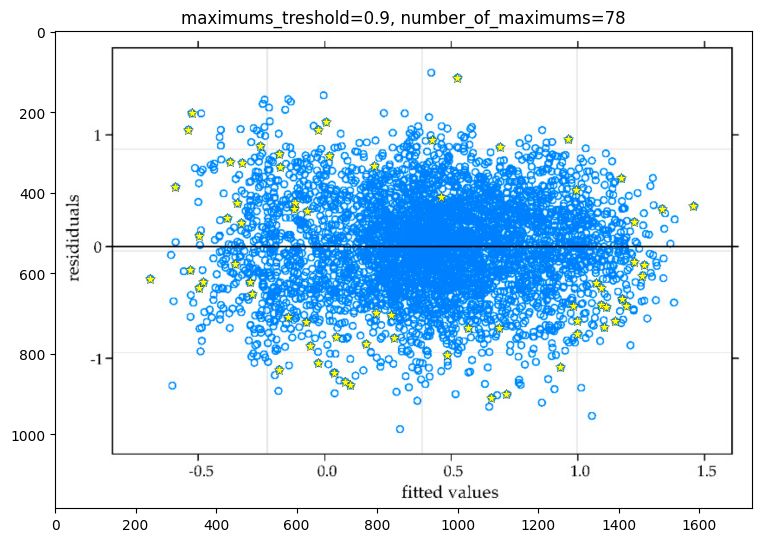

In [249]:
CORR_MAP = convolution_map_final**2
iou_treshold = 0.9
maximums_treshold = 0.9


## get max points
maximums = np.where(CORR_MAP >= maximums_treshold)
y_points, x_points = maximums
points = np.stack((x_points, y_points)).T
number_of_maximums = len(points)

## NMS
bboxes, scores = get_bbox_from_point(points, w_template, h_template, CORR_MAP)
keep = nms(bboxes, scores, iou_threshold=iou_treshold)
bboxes_nms = bboxes[keep]
x_nms, y_nms = get_bbox_center(bboxes_nms)
actual_points = np.stack((x_nms, y_nms)).T

## nms: founded points on original image
plt.figure(figsize=(9, 9))
draw_image(source_image)
plt.scatter(x_nms, y_nms, s=60, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
# plt.xticks([]); plt.yticks([]);
plt.title(f"{maximums_treshold=}, {number_of_maximums=}")
plt.show()

In [250]:
res = reconstruction(image, template, template_mask, y_points, x_points)

Text(0.5, 1.0, 'energy = 68959350')

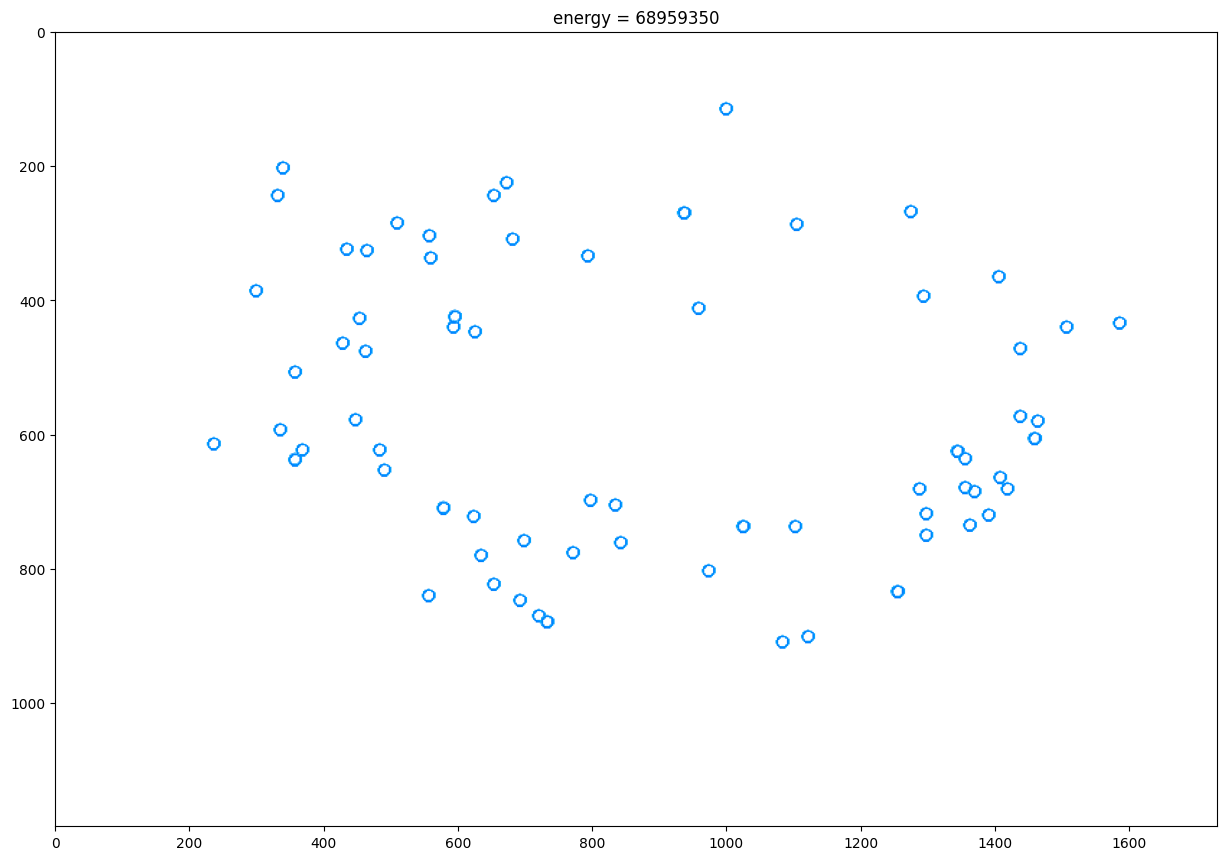

In [251]:
plt.figure(figsize=(15, 15))
draw_image(res)

energy = cv.matchTemplate(image, template, cv.TM_SQDIFF_NORMED, mask=None)

plt.title(f"energy = {np.sum((res - image)**2)}")

## NMS

In [29]:
from lsnms import nms

In [30]:
N_maximums = 543

## get max points
maximums = get_first_N_maximums(convolution_map4, N_maximums)
# maximums = get_first_N_maximums(convolution_map3, N_maximums)
y_points = np.array( [pt[1][0] for pt in maximums] )
x_points = np.array( [pt[1][1] for pt in maximums] )
points = np.stack((x_points, y_points)).T

In [31]:
points

array([[ 750,  227],
       [ 743,  226],
       [ 861,  254],
       ...,
       [1141,  323],
       [ 496,  152],
       [1087,   83]])

In [34]:
bboxes, scores = get_bbox_from_point(points, w_template, h_template, convolution_map)

In [22]:
# bboxes = []
# scores = []

# for point in points:
#     bbox = point_to_bbox(*point[::-1], w_template, h_template, convolution_map4)
#     bboxes.append(bbox)
#     scores.append(convolution_map4[point[1], point[0]])
# bboxes = np.array(bboxes)
# scores = np.array(scores)

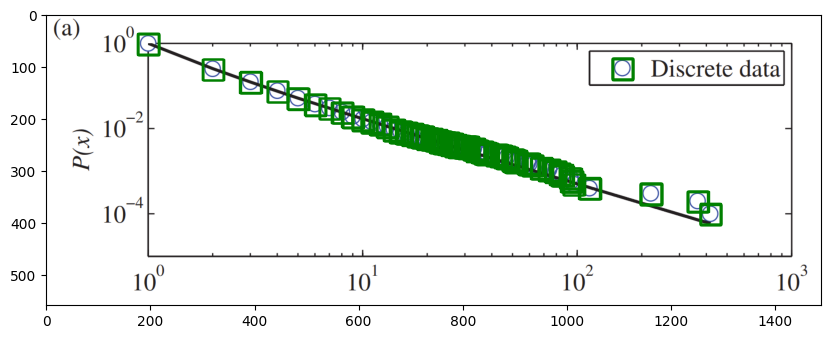

In [35]:
## founded points on original image
plt.figure(figsize=(10, 6))
draw_image(source_image)

for bbox in bboxes:
    x_min, y_min, x_max, y_max = bbox
    draw_bbox(x_min, x_max, y_min, y_max, color='g')
    
plt.show()

In [247]:
# keep = nms(bboxes, scores, iou_threshold=0.5)

In [37]:
@interact(treshold=widgets.FloatSlider(value=0.01, min=0.01, max=0.99, step=0.01))
def visualize2(treshold):

    keep = nms(bboxes, scores, iou_threshold=treshold)
    bboxes_nms = bboxes[keep]

    ## founded points on original image
    plt.figure(figsize=(12, 12))
    draw_image(source_image)

    x_center, y_center = get_bbox_center(bboxes_nms)
    plt.scatter(x_center, y_center, s=60, c="yellow", marker="*",  edgecolors='black', linewidths=0.4)
    plt.show()


    ## bboxes on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)

    for bbox in bboxes_nms:
        x_min, y_min, x_max, y_max = bbox
        draw_bbox(x_min, x_max, y_min, y_max, color='g')
        
    plt.show()

interactive(children=(FloatSlider(value=0.01, description='treshold', max=0.99, min=0.01, step=0.01), Output()…

## Pipeline 2 (corr map from strach)

In [272]:
PLOT_NUMBER = 31
MARKER_NUMBER = 3

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [273]:
source_image = read_image_rgb(PLOT_PATH)
template_rgb = read_image_rgb(TEMPLATE_PATH)

In [274]:
h_image, w_image = source_image.shape[0], source_image.shape[1]
h_template, w_template = template_rgb.shape[0], template_rgb.shape[1]

h_image, w_image

(435, 553)

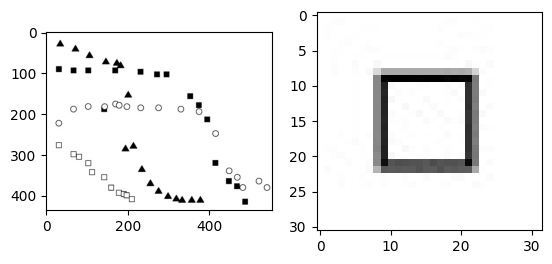

In [275]:
plt.subplot(1, 2, 1)
draw_image(source_image)

plt.subplot(1, 2, 2)
draw_image(template_rgb)

([], [])

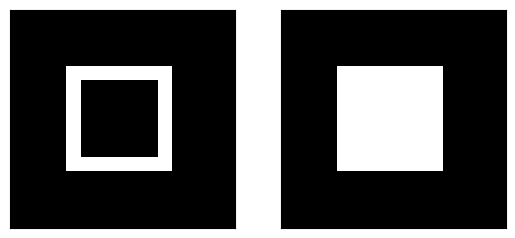

In [276]:
TRESHOLD_VALUE = 230
template_mask = template_tresholding(template_rgb, TRESHOLD_VALUE)
new_template_mask = reconstruct_template_mask(template_mask)

template_mask_rgb = np.zeros((template_mask.shape[0], template_mask.shape[1], 3))
template_mask_rgb[:, :, 0] = template_mask
template_mask_rgb[:, :, 1] = template_mask
template_mask_rgb[:, :, 2] = template_mask

new_template_mask_rgb = np.zeros((new_template_mask.shape[0], new_template_mask.shape[1], 3))
new_template_mask_rgb[:, :, 0] = new_template_mask
new_template_mask_rgb[:, :, 1] = new_template_mask
new_template_mask_rgb[:, :, 2] = new_template_mask

fig = plt.figure()
plt.subplot(1, 2, 1)
draw_image(template_mask)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(new_template_mask)
plt.xticks([]); plt.yticks([])

**Replace black pixels**

In [277]:
image = replace_black_pixels(source_image)
template = replace_black_pixels(template_rgb)

DEBUG - template_match.py - replace_black_pixels: Number of black pixels on image: 3487
DEBUG - template_match.py - replace_black_pixels: Number of black pixels on image: 6


**Image tresholding**

In [278]:
MASK_VALUE = 0

image_mask = template_tresholding(image, treshold=TRESHOLD_VALUE)
indexes_background = np.where(image_mask == 0)
image_with_mask = np.copy(image)
image_with_mask[indexes_background] = MASK_VALUE

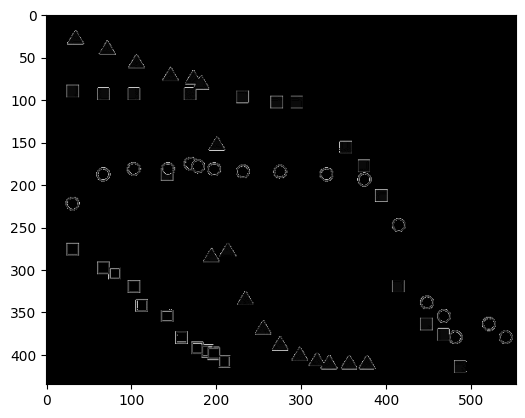

In [279]:
plt.imshow(image_with_mask)

**Binary masks**

In [280]:
assert np.all(np.unique(template_mask) == np.array([0, 255]))
assert np.all(np.unique(image_mask) == np.array([0, 255]))
assert len(template_mask.shape) == 2
assert len(image_mask.shape) == 2

template_mask_binary = template_mask / 255
image_mask_binary = image_mask / 255

template_non_mask_pixels_count = np.sum(template_mask_binary)

In [281]:
# imshow_interactive(image_mask_binary)

In [282]:
# mask_part = get_image_part(304, 434, image_mask_binary, w_template, h_template)
# imshow_interactive(mask_part)

In [283]:
# imshow_interactive(template_mask_binary)

In [284]:
# imshow_interactive(mask_part * template_mask_binary)

In [285]:
# compute_mask_pixel_ratio_v2(mask_part, template_mask_binary, np.sum(template_mask_binary))

In [286]:
# # method_name = 'SOME_CUSTOM_METHOD'
# method = "cv.TM_SQDIFF_NORMED"

# corr_map, _ = template_match(image, template_rgb, template_mask, method)
# corr_map2, _ = template_match(image, template_rgb, new_template_mask, method)

# corr_map3 = corr_map + 0.5 * corr_map2

In [302]:
# method_name = "CUSTOM_SQDIFF"

corr_map_height = h_image - h_template + 1
corr_map_width = w_image - w_template + 1
corr_map = np.zeros((corr_map_height, corr_map_width), dtype=np.float64)

image = image.astype(np.float64)
template = template.astype(np.float64)
template_mask_rgb = template_mask_rgb.astype(np.float64)

for y in tqdm(range(corr_map_height)):
    for x in range(corr_map_width):
        image_part = get_image_part(y, x, image, w_template, h_template)
        image_mask_part_binary = get_image_part(y, x, image_mask_binary, w_template, h_template)

        # corr_value = sqdiff_normed(image_part, template, template_mask_rgb)
        corr_value = sqdiff_normed_modification(
            image_part,
            template,
            template_mask_rgb,
            image_mask_part_binary,
            template_mask_binary,
            template_non_mask_pixels_count,
            ratio_treshold=0.8
        )
        corr_map[y, x] = corr_value

  0%|          | 0/405 [00:00<?, ?it/s]

In [303]:
assert not np.any(np.isinf(corr_map)), "There are INF alues on map"

In [304]:
corr_map2 = np.copy(corr_map)
corr_map2 = invert_convolution_map(corr_map2)
corr_map2 = normalize_map(corr_map2)

In [640]:
# imshow_interactive(corr_map2)

In [306]:
# method_name = "CUSTOM_SQDIFF"

corr_map_second_mask = np.zeros((corr_map_height, corr_map_width), dtype=np.float64)

image = image.astype(np.float64)
template = template.astype(np.float64)
new_template_mask_rgb = new_template_mask_rgb.astype(np.float64)

for y in tqdm(range(corr_map_height)):
    for x in range(corr_map_width):
        image_part = get_image_part(y, x, image, w_template, h_template)

        corr_value = sqdiff_normed(image_part, template, new_template_mask_rgb)
        corr_map_second_mask[y, x] = corr_value

  0%|          | 0/405 [00:00<?, ?it/s]

In [307]:
assert not np.any(np.isinf(corr_map_second_mask)), "There are INF alues on map"

In [308]:
corr_map_second_mask2 = np.copy(corr_map_second_mask)
corr_map_second_mask2 = invert_convolution_map(corr_map_second_mask2)
corr_map_second_mask2 = normalize_map(corr_map_second_mask2)

In [309]:
# imshow_interactive(corr_map_second_mask2)

In [310]:
corr_map3 = corr_map2 + 0.5 * corr_map_second_mask2

In [313]:
corr_map_final = remove_nan_inf(corr_map3)
corr_map_final = normalize_map(corr_map_final)

DEBUG - utils.py - remove_nan_inf: Number of NaN values: 211265
DEBUG - utils.py - remove_nan_inf: Number of inf values: 0


In [641]:
# imshow_interactive(corr_map_final)

In [248]:
MAXIMUMS_NUMBER_LIMIT = 200


@interact(N_maximums=widgets.FloatSlider(value=1, min=1, max=MAXIMUMS_NUMBER_LIMIT, step=1),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(N_maximums, eps):

    ## get max points
    N_maximums = int(N_maximums)
    maximums = get_first_N_maximums(corr_map_final, N_maximums)
    y_points = np.array( [pt[1][0] for pt in maximums] )
    x_points = np.array( [pt[1][1] for pt in maximums] )
    points = np.stack((x_points, y_points)).T

    ## clustering
    cluster_labels = meanshift_clustering(points, eps)
    # cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(9, 9))
    draw_image(source_image)
    x += w_template // 2
    y += h_template // 2
    plt.scatter(x, y, s=50, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
    # plt.xticks([]); plt.yticks([]);
    plt.title(f"{N_maximums=}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=1.0, description='N_maximums', max=200.0, min=1.0, step=1.0), FloatSli…